<a href="https://colab.research.google.com/github/Doquey/Facerecognizer/blob/main/Facerecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


#Resolução da questão 3

Nota: Apenas uma parte do banco de dados original foi utilizada para a resolução desta questão. O motivo foi que o google colab estava com problemas para carregar todos os dados.



---


Nosso objetivo nesse problema, de forma geral, é encontrar um vetor que consiga,precisamente, extrair caracteristicas faciais de uma image (lhe damos o nome de vetor descritor). Na primeira parte desta questão irei utilizar o metodo das redes neurais siamesas, um metodo que é recomendado para o nosso tipo de problema. A teoria por trás das redes neurais siamesas é a de que devemos passar dois inputs distintos para duas redes identicas, e com base nesses inputs computaremos um vetor descritor que otimize a distância entre as classes dos nossos inputs. Com otimizar as classes, oque quero dizer é que nossa rede será treinada de forma a nos dar a maior distância entre inputs de classe diferente e a menor distância entre inputs de mesma classe

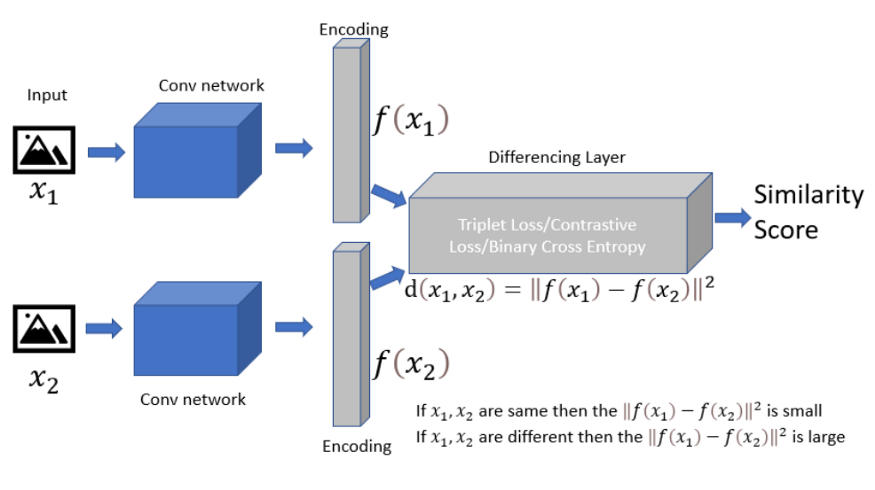


---
Imagem retirada do link : https://medium.com/swlh/siamese-network-for-facial-recognition-5bd33be9e381


---


Antes de começar a montar e treinar os modelos, precisamos primeiro fazer o upload dos dados. Para isso utilizaremos a função create_train, montada abaixo. A função create_train, é responsavel por fazer um looping por todas as classes e coletar e atribuir labels para as imagens daquela classe.

In [ ]:
import os
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import random
from keras import backend as K
import math

targets = []
base_dir = '/content/drive/My Drive/Colab Notebooks/Daedalus Problemas/Problema3/dataset/'

#loop sobre todas as pessoas na pasta post-processed e pega o nome de cada uma
for target in os.listdir(base_dir):  
    targets.append(target)



---


Load dos dados


---



In [ ]:
#Essa função faz o load dos arquivos em base_dir e da uma label pra cada uma das pastas com base no index da pessoa em targets
def create_train(targets,base_dir):
    features =[]
    labels = []
    for target in targets:
        label = targets.index(target)
        path = os.path.join(base_dir,target)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            img_array = cv.imread(img_path)
            labels.append(label)
            features.append(img_array)

    return (features,labels)

features,labels = create_train(targets,base_dir)
#transformando as listas em np.arrays
features = np.array(features,dtype='uint8')/255.0
labels = np.array(labels)



---


Separamos os dados em Treino e validação e capturamos as labels unicas do nosso banco de dados(ou a quantidade de pessoas unicas no banco de dados)


---



In [ ]:
#pegamos a quantidade de pessoas no banco de dados, para ser posteriormente utilizada como numero de unidades do output layer da nossa primeira rede.
n_classes = np.unique(labels)
#fazemos a divisão do banco de dados para treino e validação
X_train,X_val,Y_train,Y_val = train_test_split(features,labels,test_size=0.2)

#Funções que serão uteis no desenvolvimento do projeto

In [ ]:
#Essa função é responsavel por colocar nossas imagens em pares, para inputadas na rede siamesa como pares positivos e negativos.
def create_pairs(images, labels,n_classes):
    random.seed(1)
    pairImages = []
    pairLabels = []
    
    # Loop sobre todas as imagens
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        
        # seleciona, de forma randomica, uma imagem com a mesma label que a imagem atual
        posId = random.choice(list(np.where(labels == label)))
        posIdx =random.choice(posId)
        posImage = images[posIdx]
        
        # coloca o par imagem atual x posImage na pairImages e atribui 1 para o mesmo index em pairLabels
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        #seleciona, novamente, de forma randomica, uma imagem que não tem a mesma label que a imagem atual.
        negId = random.choice(list(np.where(labels != label)))         
        negIdx =random.choice(negId)
        negImage = images[negIdx]
        
        #coloca o par imagem atual x negImage na pairImages e coloca 0 no mesmo index em pairLabels
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
   
    return (np.array(pairImages), np.array(pairLabels))

#Função para mudar o tamanho de uma determinada imagem para o tamanho exato do shape do nosso input layer. Note que em .reshape((1,112,112,3)) 
# o numero 1 na frente do shape da imagem serve para dizer ao modelo qual o tamanho do batch que queremos inputar.
def resize_img(img,shape):
  resized_img = cv.resize(img,shape)
  resized_img = np.array(resized_img,dtype='uint8')/255.0
  resized_img = resized_img.reshape((1,112,112,3))

  return resized_img


#Função que simula a função logistica ou sigmoid.
def sigmoid(x):
  return 1/(1+math.exp(-x))


#Função para conseguirmos a distância entre dois TENSORES. Para calcular a distância euclidiana entre dois tensores precisamos fazer operaçoes
# com a API keras.backend 
def euclidean(vetores):
  x,y = vetores
  soma= K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(soma,K.epsilon()))


#Essa função cria um e retorna um modelo personalizado que tem o intuito de servir como feature extractor(vamos utilizar esse vetor para fazer o embedding das nossas imagens)
def vetor_descritor(shape, embedding=64, fineTune=False):
  inputs = tf.keras.layers.Input(shape)
  base_model = tf.keras.applications.vgg19.VGG19(input_shape=shape, include_top=False,weights='imagenet')
    
  if fineTune==False:
    base_model.trainable=False
  else:
    base_model.trainable = True
  for layer in base_model.layers[:-1]:
    layer.trainable =  False
  x=base_model(inputs)
  x=tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs=tf.keras.layers.Dense(embedding,name='embedding')(x)
  model = tf.keras.Model(inputs, outputs)
    
  return model

#Função para calcular o vetor prototype de uma classe(basicamente tiramos o vetor medio de cada classe). 
def prototypes(dataset):
  prototypes_data = []
  for label in np.unique(dataset[:,-1]):
    embeddings_atual_class = pd.DataFrame(dataset[np.where(dataset[:,-1]==label)])
    prototypes_data.append((embeddings_atual_class).mean(axis=0,skipna=False))
  
  return np.array(prototypes_data)


#Função para tratarmos e inserirmos uma nova imagem ao nosso banco de dados
def insert_image(img,embedding_model,dataset):
  label = len(np.unique(dataset[:,-1])) 
  img = embedding_model.predict(img)
  img_labelled = np.column_stack((img,label))
  new_dataset = np.row_stack((dataset,img_labelled))
  return new_dataset

#Definimos a função loss constrativa que é uma função personalizada disponibilizada pelo google.
def loss(margin=1):
    

    def contrastive_loss(y_true, y_pred):
        

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


#Função que olha no nosso banco de dados de features faciais e tira a distância de uma imagem input qualquer com as demais imagems no banco.
#Com todas as distâncias calculadas, a função ira pegar a posição, ou imagem, que nos da a menor distância e retornara a pessoa a qual aquela imagem pertence.
def face_recognizer(img,dataset,embedding_model,targets):
  img = embedding_model(img)
  distance_img_overall = []
  for imgx in dataset:
    distance_img_overall.append(euclidean([img,imgx[:-1]]))
  sigmoidx = [sigmoid(dist_img) for dist_img in distance_img_overall]
  sigmoidx = np.array(sigmoidx)
  k = np.argmin(sigmoidx)
  person_label = int(dataset[k,-1])
  person = targets[person_label]
  print('A foto pertence ao(a) {}'.format(person))



---


Instanciamos pares positivos e negativos para treinar e validar o modelo.


---



In [ ]:
(train_data,train_label) = create_pairs(X_train,Y_train,n_classes)
(val_data,val_label)  = create_pairs(X_val,Y_val,n_classes)



---


Criemos então as redes siamesas, note que no nosso caso estamos interessados no layer "featuresA" ou "featuresB".


---



In [ ]:
img1 = keras.Input(shape=(112,112,3))
img2 = keras.Input(shape=(112,112,3))
vetor_descritorx = vetor_descritor((112,112,3))
featuresA = vetor_descritorx(img1)
featuresB = vetor_descritorx(img2)

80150528/80134624 [==============================] - 0s 0us/step



---


Agora que temos a rede neural que nos dara as features faciais das pessoas no banco de dados, podemos adicionar um layer que utiliza a nossa função que calcula a distância euclidiana para tensores "euclidean" para calcularmos a distância entre duas faces.


---

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config 
np_config.enable_numpy_behavior()
distancex = keras.layers.Lambda(euclidean)([featuresA,featuresB])

---


Basta agora que criemos um layer para classificação, utilizaremos uma sigmoid como ativação deste ultimo layer. O layer de classificação tera como objetivo pegar a distância entre dois vetores de features faciais, colocar essa distância entre 0 e 1 e decidir, com base num threshold, no nosso caso,0.5, se aquele é um par positivo ou negativo.


---

In [ ]:
output = keras.layers.Dense(1,activation='sigmoid')(distancex)
model2 = keras.Model(inputs=[img1,img2],outputs=output)


---


Vamos agora criar os argumentos para o modelo


---



In [ ]:
optmizer = keras.optimizers.Adam(lr=0.005)
metrics = ['accuracy']

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


---


Basta compilar e treinar o modelo



---



In [ ]:
model2.compile(optimizer=optmizer,loss=loss(margin=0.5),metrics=metrics)

model2.fit([train_data[:,0],train_data[:,1]],train_label[:],batch_size=1,epochs=20,validation_data=([val_data[:,0],val_data[:,1]],val_label[:]))

Epoch 1/20
252/252 [==============================] - 97s 379ms/step - loss: 0.0608 - accuracy: 0.4921 - val_loss: 0.0255 - val_accuracy: 0.5000
Epoch 2/20
252/252 [==============================] - 95s 377ms/step - loss: 0.0347 - accuracy: 0.5000 - val_loss: 0.0230 - val_accuracy: 0.5000
Epoch 3/20
252/252 [==============================] - 95s 377ms/step - loss: 0.0234 - accuracy: 0.6429 - val_loss: 0.0275 - val_accuracy: 0.8594
Epoch 4/20
252/252 [==============================] - 95s 378ms/step - loss: 0.0167 - accuracy: 0.6468 - val_loss: 0.0247 - val_accuracy: 0.8594
Epoch 5/20
252/252 [==============================] - 95s 379ms/step - loss: 0.0118 - accuracy: 0.6905 - val_loss: 0.0251 - val_accuracy: 0.8906
Epoch 6/20
252/252 [==============================] - 96s 380ms/step - loss: 0.0083 - accuracy: 0.7183 - val_loss: 0.0166 - val_accuracy: 0.8594
Epoch 7/20
252/252 [==============================] - 96s 380ms/step - loss: 0.0058 - accuracy: 0.7659 - val_loss: 0.0167 - val_ac



---
Pronto, agora temos o modelo treinado e, portanto, podemos transferir os layers que queremos de forma a criar um vetor descritor de uma face qualquer.


---




In [ ]:
vetor_treinado = model2.layers[-3]


for layer in vetor_treinado.layers:
  layer.trainable=False



---


Vamos utilizar o modelo vetor_treinado para transformar nossas imagens em vetores faciais.


---



In [ ]:
features_dataset = vetor_treinado.predict(features)



---


Agora vamos criar o nosso dataset com as features faciais das imagens e suas respectivas labels


---



In [ ]:
features_dataset_siamese = np.column_stack((features_dataset,labels))



---


façamos o upload das imagens que utlizaremos para teste. A img1 será inserida no banco de dados e a img2 será a que utlizaremos para testar nosso face_recognizer.


---



In [ ]:
img1 = cv.imread('/content/drive/My Drive/Colab Notebooks/Daedalus Problemas/Problema3/imagens para teste/marcelinho_no_db.jpg')
img2 = cv.imread('/content/drive/My Drive/Colab Notebooks/Daedalus Problemas/Problema3/imagens para teste/marcelinho_na_inferencia.jpg')




---


Fazemos o resize das imagens de forma a não ter conflito com o tamanho do input do vetor descritor.


---



In [ ]:
#resize images
img1_resized =resize_img(img1,(112,112))
img2_resized =resize_img(img2,(112,112))



---


Vamos adicionar a img1 ao banco de dados e calcular os prototipos para cada classe em armazenar em prototypes.



---





In [ ]:
new_dataset = insert_image(img1_resized,vetor_treinado,features_dataset_siamese)
prototypesx = prototypes(new_dataset)




---


Vamos adicionar o nome da pessoa da imagem aos targets


---



In [ ]:
targets.append('Marcelo')



---


Agora ja podemos rodar o face_recognizer na imagem 2


---



In [ ]:
face_recognizer(img2_resized,prototypesx,vetor_treinado,targets)

A foto pertence ao(a) Marcelo


Conclusão:

O modelo, apesar de não ter sido treinado em sua capacidade total, conseguio de forma muita clara colocar embeddings de diferentes classes em diferentes clusters. Note que o modelo apresentado poderia ser melhorado com a aplicação de uma função que calculasse a distância mahalanobiana, invés da euclidiana. Isso se da pelo fato de a primeira ser mais abrangente e levar em consideração as classes quando fazendo o calculo. No mais, gostaria ainda de salientar que um metodo alternativo a este para o reconhecimento facil seria a criação de uma CNN convencional, e a aplicação do seu feature extractor nas imagens do dataset e então poderiamos repetir o mesmo processo que fizemos aqui: olhar no dataset e comparar as distâncias entre imagens.

Referencias:

https://keras.io/examples/vision/siamese_contrastive/

https://towardsdatascience.com/the-why-and-the-how-of-deep-metric-learning-e70e16e199c0

https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463

https://medium.com/swlh/siamese-network-for-facial-recognition-5bd33be9e381
